In [1]:
import os
import os.path

from urllib.parse import urlparse
from urllib.parse import parse_qs
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import boto3
import numpy as np
import pandas as pd

# Data Challenge

Files are stored in an S3 bucket. The purpose here is to work out methods to process the data properly. There is a lot of scratch work that is not explained, but there are some observations about the data below.

## Bucket Contents and File Download

In [2]:
s3 = boto3.resource('s3')
bucket_name = "postie-testing-assets"

In [3]:
test = s3.Bucket(bucket_name)

In [4]:
s3.meta.client.head_bucket(Bucket=bucket_name)

{'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Wed, 18 Oct 2017 14:16:20 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-bucket-region': 'us-east-1',
   'x-amz-id-2': 'r0MvQsrnNPv2cYn5roGk88QwMSU4hFswFDE28rPwcAYH73jx3Mb1uR7rNVrDQ1OOgRGN8AeIQWQ=',
   'x-amz-request-id': '6A90346B37412C6E'},
  'HTTPStatusCode': 200,
  'HostId': 'r0MvQsrnNPv2cYn5roGk88QwMSU4hFswFDE28rPwcAYH73jx3Mb1uR7rNVrDQ1OOgRGN8AeIQWQ=',
  'RequestId': '6A90346B37412C6E',
  'RetryAttempts': 0}}

In [5]:
for key in test.objects.all():
    print(key.key)

2017-07-01.csv
2017-07-02.csv
2017-07-03.csv


An alternative is to download the data using

```aws s3 cp --recursive s3://my_bucket_name local_folder```


-
## Observations

1. Analyst is correct - July 3rd *file* has sales of $164,065. There are fewer sales and customers on the 3rd than the other two days, so the sales amount is lower. However, there are problems with the data files, so there are sales recorded on the 3rd found in files labeled for the 2nd and 3rd. There are sales recorded on the 2nd found in the files labeled for the 1st and 2nd. To get accurate sales data we will have to group by transaction date - the sales date parsed from the *timestamp* field.
2. The *placeholder* field is empty for two files, so it's probably not meaningful. Regardless, it will not add anything to prediction.
3. *app_version* may or may not be meaningful. There is only one app_version for the files labeled "2017-07-01" and "2017-07-02". The remaining file has two app_versions - 1.1 and 1.2. This field is probably not meaningful for prediction, but sales on the 3rd should be examined for the different app_versions.

## Plans
- Get the items. But should we make new columns in the original dataset?
- Items are paired with item counts.
- We would like to know the sales by domain and by item.
- We would like to know the corrected sales by date.
- Average sales is not meaningful - explain why.
- Sales prediction at the aggregate level is not meaningful - there are only two values per domain.
- So do we predict sales at the item level? If so, how?
- What do we do with the *app_version*?
- What are the values in *placeholder*?
- Explain why average sales for a day is not meaningful.

In [6]:
def convert_list(query_string):
    """Parse the query string of the url into a dictionary.
    
    Handle special cases:
    - There is a single query "error=True" which is rewritten to 1 if True, else 0.
    - Parsing the query returns a dictionary of key-value pairs. The value is a list.
      We must get the list value as an int.
      
    Note: This function may be a bottleneck when processing larger data files.
    """
    def handle_error(z, col):
        """
        Called in the dictionary comprehension below to handle the "error" key.
        """
        if "error" in col:
            return 1 if "True" in z else 0
        return z
    dd = parse_qs(query_string)
    return {k: int(handle_error(dd[k][0], k)) for k in dd}

In [31]:
fr = pd.DataFrame()
col_names = ["timestamp", "website_id", "customer_id", "app_version", "placeholder", "checkout_amount", "url"]
data_report = []
item_lists = []
for fname in os.listdir("data"):
    ffr = pd.read_csv(os.path.join("data", fname),
                      header=0, names=col_names,
                      infer_datetime_format=True, parse_dates=[0])
    file_date = fname.split(".")[0]
    ffr["file_date"] = file_date
    transaction_date = ffr.timestamp.apply(lambda x: x.strftime('%Y-%m-%d'))  # reformat transaction timestamp
    ffr["transaction_date"] = transaction_date
    url_items = ffr.url.apply(lambda x: urlparse(x))
    domain_name = url_items.apply(lambda x: x[1])
    item_query = url_items.apply(lambda x: x[4])
    qq = item_query.apply(lambda x: convert_list)
    # handle store.example.com and www.example.com as the same website
    ffr["domain_name"] = domain_name.apply(lambda x: x if not "example.com" in x else ".".join(x.split(".")[1:]))
    item_query = url_items.apply(lambda x: x[4])
    qq = item_query.apply(lambda x: convert_list(x)).apply(pd.Series).fillna(value=0)
    item_lists += qq.columns.tolist()
    final_fr = ffr.join(qq)
    print("date {} has {} sales for rows {} and unique dates {}".format(fname, ffr.checkout_amount.sum(),
                                                                        ffr.shape[0],
                                                                        transaction_date.unique().shape[0]))
    data_report.append({"file_date": file_date, "sales": ffr.checkout_amount.sum(),
                        "n_placeholder_nan": sum(ffr.placeholder.isnull()),
                        "n_rows": ffr.shape[0],
                        "n_websites": ffr.website_id.unique().shape[0],
                        "n_customers": ffr.customer_id.unique().shape[0],
                        "n_app_versions": ffr.app_version.unique().shape[0],
                        "n_dates": transaction_date.unique().shape[0]})
    fr = fr.append(final_fr)
fr.reset_index(drop=True, inplace=True)
item_lists = list(set(item_lists))
fr.shape

date 2017-07-02.csv has 183294.0 sales for rows 11573 and unique dates 2
date 2017-07-01.csv has 241491.0 sales for rows 11634 and unique dates 2
date 2017-07-03.csv has 164065.0 sales for rows 9981 and unique dates 1


(33188, 21)

In [8]:
fr.head()

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,...,checkout_amount,customer_id,domain_name,error,file_date,placeholder,timestamp,transaction_date,url,website_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,9418,example.com,NaN,2017-07-02,NaN,2017-07-02 07:00:35,2017-07-02,http://www.example.com/store/?Ume=1,123
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3872,xyz.com,NaN,2017-07-02,NaN,2017-07-02 07:00:37,2017-07-02,http://xyz.com/checkout?Prairie+Potato=1,124
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3090,example.com,NaN,2017-07-02,NaN,2017-07-02 07:00:47,2017-07-02,http://www.example.com/store/?Hazelnut=1,123
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,9556,xyz.com,NaN,2017-07-02,NaN,2017-07-02 00:00:51,2017-07-02,http://xyz.com/checkout?Ume=1,124
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,8845,xyz.com,NaN,2017-07-02,NaN,2017-07-02 00:01:02,2017-07-02,http://xyz.com/checkout?Bignay=1,124


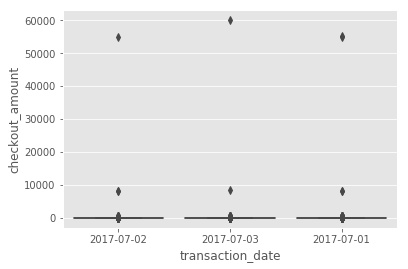

In [12]:
sns.boxplot(x="transaction_date", y="checkout_amount", data=fr)

In [317]:
pt = pd.pivot_table(fr, values="checkout_amount", index="transaction_date", columns="domain_name",
               aggfunc=[np.sum], margins=False)

sum          
domain_name      example.com   xyz.com
transaction_date                      
2017-07-01          172874.0   50641.0
2017-07-02          127786.0   55966.0
2017-07-03           64599.0  116984.0

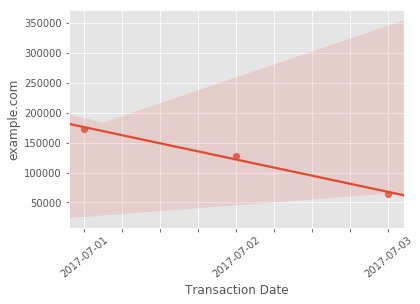

,example.com,xyz.com,row_count
2017-07-01,172874.0,50641.0,1
2017-07-02,127786.0,55966.0,2
2017-07-03,64599.0,116984.0,3


In [345]:
from scipy.stats import linregress
pt = pd.pivot_table(fr, values="checkout_amount", index="transaction_date", columns="domain_name",
               aggfunc=[np.sum], margins=False)
pt.columns = ['example.com', 'xyz.com']
pt.index = pd.DatetimeIndex(pt.index)
idx = pd.date_range(pt.index.min(), pt.index.max())
pt = pt.reindex(index=idx)
pt.insert(pt.shape[1],
          'row_count',
          pt.index.value_counts().sort_index().cumsum())
ax = sns.regplot(data=pt, x="row_count", y="example.com")
xticks = ax.get_xticks()
labels = ['' for item in ax.get_xticklabels()]
labels[1] = pt.index[0].date()
labels[5] = pt.index[1].date()
labels[9] = pt.index[2].date()
ax.set_xticklabels(labels)
plt.xticks(rotation=40)
plt.xlabel("Transaction Date")
plt.show()
pt

In [344]:
slope, intercept, r_value, p_value, std_err = linregress(x=ax.get_lines()[0].get_xdata(),y=ax.get_lines()[0].get_ydata())
print("Predicted sales 7/4/2014 is {}".format(intercept + slope * 4))

Predicted sales 7/4/2014 is 13478.000000000204


In [375]:
ax.get_xticks()

array([ 0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,
        3.  ,  3.25])

In [376]:
pt.row_count

2017-07-01    1
2017-07-02    2
2017-07-03    3
Freq: D, Name: row_count, dtype: int64

In [18]:
def convert_list(x):
    def handle_error(z, col):
        if "error" in col:
            return 1 if "True" in z else 0
        else:
            return z
    dd = parse_qs(x)
    return {k: int(handle_error(dd[k][0], k)) for k in dd}

In [35]:
url_results = fr.url.apply(lambda x: urlparse(x))
domain_names = url_results.apply(lambda x: x[1])
item_query = url_results.apply(lambda x: x[4])
qq = item_query.apply(lambda x: convert_list(x))
qq = qq.apply(pd.Series).fillna(value=0)

In [33]:
dd = parse_qs(item_query[20])
ddd = {k: int(dd[k][0]) for k in dd}
ddd
# for k in dd:
#     dd[k] = int(dd[k][0])

{'Round Kumquat': 1, 'Ume': 1}

In [36]:
qq.head()

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,error
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
for it in item_query:
    if "True" in it:
        print(it)

Bignay=1&error=True


In [11]:
url_results.shape

(33188,)

In [116]:
url_results = pd.concat([fr.timestamp, fr.customer_id, qq], axis=1)

In [117]:
url_results.head(10)

,timestamp,customer_id,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,error
0,2017-07-02 07:00:35,9418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2017-07-02 07:00:37,3872,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2017-07-02 07:00:47,3090,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-07-02 00:00:51,9556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2017-07-02 00:01:02,8845,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2017-07-02 00:01:14,6008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2017-07-02 00:01:18,5312,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,2017-07-02 07:01:33,9178,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2017-07-02 07:01:55,1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,2017-07-02 07:01:55,275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
int(url_results.url[0]["Ume"][0])

1

In [30]:
url_results["url"].apply(pd.Series) #.apply(lambda x: int(0 if np.isnan(x[0]) else x[0])) #.fillna(value=0) #.apply(lambda x: int(x[0]))

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,error
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN
4,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN,NaN,NaN,NaN
7,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,[1],NaN,NaN,NaN,NaN


In [31]:
new_cols = url_results["url"].apply(pd.Series).fillna(value=0)

KeyError: 'url'

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,error
0,0,0,0,0,0,0,0,0,[1],0,0
1,0,0,0,0,0,0,[1],0,0,0,0
2,0,0,0,[1],0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,[1],0,0
4,[1],0,0,0,0,0,0,0,0,0,0


In [49]:
new_cols.shape

(33188, 11)

In [57]:
for col in new_cols.columns:
    print(new_cols[col].unique())

TypeError: unhashable type: 'list'

In [44]:
int(new_cols["Bignay"][4][0])

1

In [53]:
def convert_to_num(x):
    if isinstance(x, list):
        try:
            xx = int(x[0])
        except Exception as ex:
            print(x[0])
        return int(x[0])
    else:
        return x

In [54]:
frames = [new_cols[col].apply(convert_to_num) for col in new_cols.columns]

True


ValueError: invalid literal for int() with base 10: 'True'

In [124]:
pr = urlparse("http://xyz.com/checkout?Ume=1")

In [127]:
pr

ParseResult(scheme='http', netloc='xyz.com', path='/checkout', params='', query='Ume=1', fragment='')

In [37]:
fr.head()

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,...,checkout_amount,customer_id,domain_name,error,file_date,placeholder,timestamp,transaction_date,url,website_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,9418,example.com,NaN,2017-07-02,NaN,2017-07-02 07:00:35,2017-07-02,http://www.example.com/store/?Ume=1,123
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.0,3872,xyz.com,NaN,2017-07-02,NaN,2017-07-02 07:00:37,2017-07-02,http://xyz.com/checkout?Prairie+Potato=1,124
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3090,example.com,NaN,2017-07-02,NaN,2017-07-02 07:00:47,2017-07-02,http://www.example.com/store/?Hazelnut=1,123
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,6.0,9556,xyz.com,NaN,2017-07-02,NaN,2017-07-02 00:00:51,2017-07-02,http://xyz.com/checkout?Ume=1,124
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,8845,xyz.com,NaN,2017-07-02,NaN,2017-07-02 00:01:02,2017-07-02,http://xyz.com/checkout?Bignay=1,124


In [30]:
item_cols = new_cols.columns.tolist()

NameError: name 'new_cols' is not defined

In [13]:
fr[item_lists + ['checkout_amount', 'timestamp', 'domain_name', 'transaction_date', 'customer_id']]

,Bignay,Hazelnut,Ylang-ylang,Mabolo,Ume,Natal Orange,Prairie Potato,Black/White Pepper,Round Kumquat,error,European Grape,checkout_amount,timestamp,domain_name,transaction_date,customer_id
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 07:00:35,example.com,2017-07-02,9418
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,3.0,2017-07-02 07:00:37,xyz.com,2017-07-02,3872
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,4.0,2017-07-02 07:00:47,example.com,2017-07-02,3090
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 00:00:51,xyz.com,2017-07-02,9556
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 00:01:02,xyz.com,2017-07-02,8845
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,5.0,2017-07-02 00:01:14,example.com,2017-07-02,6008
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 00:01:18,xyz.com,2017-07-02,5312
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 07:01:33,xyz.com,2017-07-02,9178
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,6.0,2017-07-02 07:01:55,xyz.com,2017-07-02,1680
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,3.0,2017-07-02 07:01:55,example.com,2017-07-02,275


In [64]:
# data structure
# - transaction_timestamp
# - domain name
# - item
# - price
#ffr = fr[item_lists + ['checkout_amount', 'timestamp', 'domain_name', 'transaction_date', 'customer_id']]
fr[fr[item_lists].astype(bool).sum(axis=1) == 1].drop(["error"], axis=1).head()

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,app_version,checkout_amount,customer_id,domain_name,file_date,placeholder,timestamp,transaction_date,url,website_id
23207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.1,5.0,4877,xyz.com,2017-07-03,NaN,2017-07-03 07:00:12,2017-07-03,http://xyz.com/checkout?Ylang-ylang=1,124
23208,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,3.0,3608,xyz.com,2017-07-03,NaN,2017-07-03 00:00:24,2017-07-03,http://xyz.com/checkout?Prairie+Potato=1,124
23209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.1,7.0,2932,example.com,2017-07-03,NaN,2017-07-03 00:00:32,2017-07-03,http://www.example.com/store/?Round+Kumquat=1,123
23210,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,6.0,1529,example.com,2017-07-03,NaN,2017-07-03 07:00:32,2017-07-03,http://www.example.com/store/?Bignay=1,123
23211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.1,7.0,2525,example.com,2017-07-03,NaN,2017-07-03 00:00:37,2017-07-03,http://www.example.com/store/?Round+Kumquat=1,123


In [183]:
cols = [item for item in item_lists if not "error" in item]
pricing_temp = fr[fr[cols].astype(bool).sum(axis=1) == 1].drop(["error"], axis=1)
pricing_temp.drop_duplicates(subset=cols + ["domain_name", "transaction_date"], inplace=True)
pricing_temp

,Bignay,Black/White Pepper,European Grape,Hazelnut,Mabolo,Natal Orange,Prairie Potato,Round Kumquat,Ume,Ylang-ylang,app_version,checkout_amount,customer_id,domain_name,file_date,placeholder,timestamp,transaction_date,url,website_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.1,6.0,9418,example.com,2017-07-02,NaN,2017-07-02 07:00:35,2017-07-02,http://www.example.com/store/?Ume=1,123
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,3.0,3872,xyz.com,2017-07-02,NaN,2017-07-02 07:00:37,2017-07-02,http://xyz.com/checkout?Prairie+Potato=1,124
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,4.0,3090,example.com,2017-07-02,NaN,2017-07-02 07:00:47,2017-07-02,http://www.example.com/store/?Hazelnut=1,123
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.1,6.0,9556,xyz.com,2017-07-02,NaN,2017-07-02 00:00:51,2017-07-02,http://xyz.com/checkout?Ume=1,124
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,6.0,8845,xyz.com,2017-07-02,NaN,2017-07-02 00:01:02,2017-07-02,http://xyz.com/checkout?Bignay=1,124
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,5.0,6008,example.com,2017-07-02,NaN,2017-07-02 00:01:14,2017-07-02,http://www.example.com/store/?Black%2FWhite+Pe...,123
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.1,6.0,5312,xyz.com,2017-07-02,NaN,2017-07-02 00:01:18,2017-07-02,http://xyz.com/checkout?Natal+Orange=1,124
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.1,3.0,275,example.com,2017-07-02,NaN,2017-07-02 07:01:55,2017-07-02,http://www.example.com/store/?Prairie+Potato=1,123
12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1,6.0,636,example.com,2017-07-02,NaN,2017-07-02 00:02:08,2017-07-02,http://www.example.com/store/?Bignay=1,123
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.1,7.0,1953,example.com,2017-07-02,NaN,2017-07-02 07:02:31,2017-07-02,http://www.example.com/store/?Round+Kumquat=1,123


In [180]:
pricing_temp.transpose()

,0,1,2,3,4,5,6,9,12,16,...,23852,23873,23878,24209,24279,25534,26111,26435,26874,28560
Bignay,0,0,0,0,1,0,0,0,1,0,...,0,2,2,0,0,0,0,0,0,0
Black/White Pepper,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
European Grape,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hazelnut,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
Mabolo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
Natal Orange,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,2,0,0,0,2
Prairie Potato,0,1,0,0,0,0,0,1,0,0,...,0,0,0,2,2,0,0,0,0,0
Round Kumquat,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Ume,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
Ylang-ylang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [191]:
# data structure
# - transaction_timestamp
# - domain name
# - item
# - price
price_cols = []
for col in cols:
    price_cols.append(pricing_temp["checkout_amount"]/pricing_temp[col])
pricing = pd.concat(price_cols, axis=1)
pricing.columns = cols
price_cols = [col + "_price" for col in cols]
dfr = pricing_temp.join(pricing, rsuffix="_price")[price_cols + ["transaction_date", "domain_name"]]
dfr = dfr.replace([np.inf, -np.inf], np.nan).fillna(value=0)
pd.pivot_table(dfr, values=price_cols, index="transaction_date", columns="domain_name", aggfunc=np.max).transpose()
# pd.pivot_table(dfr, values=price_cols, index=["transaction_date"], columns=["domain_name"])
# dfr = dfr.replace([np.inf, -np.inf], np.nan).fillna(value=0)
# dfrt = dfr.transpose()
# t_new_cols = ["col_" + str(col) for col in dfrt.columns.tolist()]
# dfrt.columns = t_new_cols
# dfrt = dfrt.reset_index(drop=False).rename(columns={"index": "temp"})
# dfrt.transpose()
# pd.pivot_table(dfrt, columns=["transaction_date", "domain_name"], values=t_new_cols, index="temp")
# dfr["0"]
# px_cols = [col for col in dfr.columns if not "temp" in col]
# px_cols
# pd.pivot_table(dfr, columns=index, index=["transaction_date", "domain_nam"], values=px_cols, aggfunc=np.max)
# pricing["checkout_amount"].div(pricing[cols], axis="index")
# pricing["checkout_amount"]  #.div(pricing[cols], axis=0)
# there are now values > 1 for the items, so we replace them with 1
# pricing[cols] > 1
# pricing[pricing[cols] > 1]
# pricing.transpose()

transaction_date                      2017-07-01  2017-07-02  2017-07-03
                         domain_name                                    
Bignay_price             example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Black/White Pepper_price example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0
European Grape_price     example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0
Hazelnut_price           example.com         4.0         4.0         4.0
                         xyz.com             4.0         4.0         4.0
Mabolo_price             example.com         8.0         8.0         8.0
                         xyz.com             8.0         8.0         8.0
Natal Orange_price       example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Prairie Potato_price     example.com         3.0         3.0         3.0
                         xyz.com             3.0         3.0         3.0
Round Kumquat_price      example.com         7.0         7.0         7.0
                         xyz.com             7.0         7.0         7.0
Ume_price                example.com         6.0         6.0         6.0
                         xyz.com             6.0         6.0         6.0
Ylang-ylang_price        example.com         5.0         5.0         5.0
                         xyz.com             5.0         5.0         5.0

In [74]:
dd = {}
for col in item_lists:
    if not "error" in col:
        dd[col + "_price"] = np.max(pricing[col] * pricing["checkout_amount"])
dd

{'Bignay_price': 24.0,
 'Black/White Pepper_price': 20.0,
 'European Grape_price': 20.0,
 'Hazelnut_price': 16.0,
 'Mabolo_price': 32.0,
 'Natal Orange_price': 24.0,
 'Prairie Potato_price': 12.0,
 'Round Kumquat_price': 28.0,
 'Ume_price': 24.0,
 'Ylang-ylang_price': 20.0}

In [30]:
pd.pivot_table(pricing, values="checkout_amount", index=, columns="transaction_date")

transaction_date,2017-07-03
domain_name,
example.com,5.583508
xyz.com,5.542160


In [38]:
pricing.transpose()

,23207,23208,23209,23210,23211,23212,23213,23214,23215,23217,...,33176,33177,33178,33179,33180,33181,33182,33183,33185,33186
Bignay,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Black/White Pepper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
European Grape,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Hazelnut,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Mabolo,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Natal Orange,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Prairie Potato,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
Round Kumquat,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
Ume,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
Ylang-ylang,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [18]:
pd.pivot_table(fr, values="checkout_amount", index="transaction_date", columns="domain_name",
               aggfunc=[np.sum], margins=True)

,a,b,c,d
0,1,0,0,0
1,0,2,0,0
2,0,0,0,0
3,3,0,0,1
4,0,0,6,0


In [20]:
# print(df.loc[df['B'].isin(['one','three'])])
for col in dfr.columns.tolist():
    dfr[col]

a
b
c
d


In [21]:
two = pd.DataFrame({'one' : pd.Series([10, 0, 10, 9], index=['a', 'b', 'c', 'd']), 'two' : pd.Series([0, 0, 10., 4.6], index=['a', 'b', 'c', 'd']), 'three' : pd.Series([5, -1, 7, -1], index=['a', 'b', 'c', 'd'])})

In [22]:
two

,one,three,two
a,10,5,0.0
b,0,-1,0.0
c,10,7,10.0
d,9,-1,4.6


In [26]:
dfr[dfr.astype(bool).sum(axis=1) == 1]

,a,b,c,d
0,1,0,0,0
1,0,2,0,0
4,0,0,6,0


In [363]:
gr = fr[item_lists + ["transaction_date", "domain_name", "checkout_amount"]]

In [368]:
frame = fr[item_lists + ["transaction_date", "domain_name", "checkout_amount"]]
gr = frame.groupby(["transaction_date", "domain_name"])

In [373]:
gb_frames = []
for _, group in gr:
    gb_frames.append(group.nlargest(5, "Bignay"))

In [374]:
gb_frames[0]

,Bignay,Hazelnut,Ylang-ylang,Mabolo,Ume,Natal Orange,Prairie Potato,Black/White Pepper,Round Kumquat,error,European Grape,transaction_date,domain_name,checkout_amount
15209,999.0,1015.0,958.0,1059.0,998.0,965.0,983.0,1049.0,963.0,NaN,1011.0,2017-07-01,example.com,55084.0
14280,990.0,995.0,1010.0,1020.0,981.0,999.0,1013.0,1005.0,1011.0,NaN,976.0,2017-07-01,example.com,55031.0
19493,163.0,159.0,111.0,130.0,151.0,166.0,143.0,170.0,147.0,NaN,160.0,2017-07-01,example.com,8219.0
15066,140.0,174.0,150.0,146.0,180.0,155.0,142.0,140.0,135.0,NaN,138.0,2017-07-01,example.com,8225.0
17421,16.0,11.0,9.0,6.0,15.0,7.0,7.0,14.0,8.0,NaN,7.0,2017-07-01,example.com,547.0
